<a href="https://colab.research.google.com/github/hrshah211/Face_And_Mask_Detector/blob/main/Adding_Masks_to_the_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Addding Masks to the Face Images without Masks**

Consider using GPU on Google Colab

**Installing Necessary Packages**

In [1]:
!pip install face_recognition

**Importing the Necessary Modules**

In [2]:
import os
import sys
import random
import argparse
import numpy as np
from PIL import Image, ImageFile
import urllib.request as ur
import cv2
from google.colab.patches import cv2_imshow

**Creating the class and respective methods for adding masks**

In [3]:
class FaceMasker:
    KEY_FACIAL_FEATURES = ('nose_bridge', 'chin')

    def __init__(self, face_path, mask_path, show=False, model='hog'):
        self.face_path = face_path
        self.mask_path = mask_path
        self.show = show
        self.model = model
        self._face_img: ImageFile = None
        self._mask_img: ImageFile = None

    def mask(self):
        import face_recognition

        face_image_np = face_recognition.load_image_file(self.face_path)
        face_locations = face_recognition.face_locations(face_image_np, model=self.model)
        face_landmarks = face_recognition.face_landmarks(face_image_np, face_locations)
        self._face_img = Image.fromarray(face_image_np)
        self._mask_img = Image.open(self.mask_path)

        found_face = False
        for face_landmark in face_landmarks:
            # check whether facial features meet requirement
            skip = False
            for facial_feature in self.KEY_FACIAL_FEATURES:
                if facial_feature not in face_landmark:
                    skip = True
                    break
            if skip:
                continue

            # mask face
            found_face = True
            self._mask_face(face_landmark)

        if found_face:
            if self.show:
                self._face_img.show()

            self._display()
            # save
            #self._save()

        else:
            print('Fae not Found.')

    def _mask_face(self, face_landmark: dict):
        nose_bridge = face_landmark['nose_bridge']
        nose_point = nose_bridge[len(nose_bridge) * 1 // 4]
        nose_v = np.array(nose_point)

        chin = face_landmark['chin']
        chin_len = len(chin)
        chin_bottom_point = chin[chin_len // 2]
        chin_bottom_v = np.array(chin_bottom_point)
        chin_left_point = chin[chin_len // 8]
        chin_right_point = chin[chin_len * 7 // 8]

        # split mask and resize
        width = self._mask_img.width
        height = self._mask_img.height
        width_ratio = 1.2
        new_height = int(np.linalg.norm(nose_v - chin_bottom_v))

        # left
        mask_left_img = self._mask_img.crop((0, 0, width // 2, height))
        mask_left_width = self.get_distance_from_point_to_line(chin_left_point, nose_point, chin_bottom_point)
        mask_left_width = int(mask_left_width * width_ratio)
        mask_left_img = mask_left_img.resize((mask_left_width, new_height))

        # right
        mask_right_img = self._mask_img.crop((width // 2, 0, width, height))
        mask_right_width = self.get_distance_from_point_to_line(chin_right_point, nose_point, chin_bottom_point)
        mask_right_width = int(mask_right_width * width_ratio)
        mask_right_img = mask_right_img.resize((mask_right_width, new_height))

        # merge mask
        size = (mask_left_img.width + mask_right_img.width, new_height)
        mask_img = Image.new('RGBA', size)
        mask_img.paste(mask_left_img, (0, 0), mask_left_img)
        mask_img.paste(mask_right_img, (mask_left_img.width, 0), mask_right_img)

        # rotate mask
        angle = np.arctan2(chin_bottom_point[1] - nose_point[1], chin_bottom_point[0] - nose_point[0])
        rotated_mask_img = mask_img.rotate(angle, expand=True)

        # calculate mask location
        center_x = (nose_point[0] + chin_bottom_point[0]) // 2
        center_y = (nose_point[1] + chin_bottom_point[1]) // 2

        offset = mask_img.width // 2 - mask_left_img.width
        radian = angle * np.pi / 180
        box_x = center_x + int(offset * np.cos(radian)) - rotated_mask_img.width // 2
        box_y = center_y + int(offset * np.sin(radian)) - rotated_mask_img.height // 2

        # add mask
        self._face_img.paste(mask_img, (box_x, box_y), mask_img)

    def _display(self):
        self._face_img.save("masked_face.jpg") 
    
    # Save method when done on local Systems.

    # def _save(self):
    #     path_splits = os.path.splitext(self.face_path)
    #     new_face_path = path_splits[0] + '-with-mask' + path_splits[1]
    #     self._face_img.save(new_face_path)
    #     print(f'Save to {new_face_path}')

    @staticmethod
    def get_distance_from_point_to_line(point, line_point1, line_point2):
        distance = np.abs((line_point2[1] - line_point1[1]) * point[0] +
                          (line_point1[0] - line_point2[0]) * point[1] +
                          (line_point2[0] - line_point1[0]) * line_point1[1] +
                          (line_point1[1] - line_point2[1]) * line_point1[0]) / \
                   np.sqrt((line_point2[1] - line_point1[1]) * (line_point2[1] - line_point1[1]) +
                           (line_point1[0] - line_point2[0]) * (line_point1[0] - line_point2[0]))
        return int(distance)

**Create Mask method to accept the face image and call the class methods**

In [4]:
def create_mask(image_path):
    pic_path = image_path
    mask_url = "https://raw.githubusercontent.com/hrshah211/Face_And_Mask_Detector/main/white_mask.png"
    ur.urlretrieve(mask_url, "mask.jpg")
    mask_path = "mask.jpg"    
    show = False
    model = "hog"
    FaceMasker(pic_path, mask_path, show, model).mask()

**Calling the Create Mask method and displaying the output**

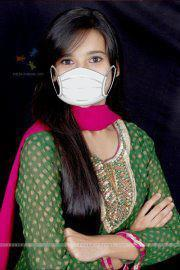

In [5]:
if __name__ == '__main__':
    image_path='https://raw.githubusercontent.com/hrshah211/Face_And_Mask_Detector/main/DataSet/WithoutMask/0.jpg'
    ur.urlretrieve(image_path, "image.jpg") 
    create_mask("image.jpg")

im = cv2.imread('masked_face.jpg')
cv2_imshow(im)